# Import libraries

In [1]:
import uproot
import awkward as ak
import mplhep
%matplotlib inline 
#%matplotlib widget
import numpy as np
import matplotlib.pyplot as plt
from brokenaxes import brokenaxes
import pandas as pd
from scipy.optimize import curve_fit

# Exercise 3: Measurement of the total production cross sections

Load Data

In [2]:
meanenergy = np.array([88.47939, 89.46793, 90.22266, 91.22430, 91.96648, 92.96465, 93.71712])
lumi = np.array([463.9790, 667.5236, 486.7641, 2246.568, 535.9080, 450.6000, 709.6980])
stat = np.array([2.902361, 3.521166, 3.033955, 6.603405, 3.265110, 3.027953, 3.819882])
sys = np.array([3.104100, 4.471900, 3.261500, 15.04780, 3.585300, 3.020000, 4.762000])
all = np.array([4.249604, 5.691792, 4.454466, 16.43293, 4.849260, 4.276552, 6.104764])

In [3]:
### Open file

file_Opal = uproot.open('daten_4.root')
ttree_name_Opal = 'myTTree'

### Print list of 'branches' of the TTree (i.e. list of variable names)
print('Opal',file_Opal[ttree_name_Opal].keys())

## Load branches
branches_Opal = file_Opal[ttree_name_Opal].arrays()

var_Pcharged = 'Pcharged'
pchar_Opal = ak.to_numpy(branches_Opal[var_Pcharged])

var_Ncharged = 'Ncharged'
nchar_Opal = ak.to_numpy(branches_Opal[var_Ncharged])

var_E_ecal = 'E_ecal'
E_ecal_Opal = ak.to_numpy(branches_Opal[var_E_ecal])

var_E_hcal = 'E_hcal'
E_hcal_Opal = ak.to_numpy(branches_Opal[var_E_hcal])

var_cos_thet = 'cos_thet'
cos_thet_Opal = ak.to_numpy(branches_Opal[var_cos_thet])

var_E_lep = 'E_lep'
E_lep_Opal = ak.to_numpy(branches_Opal[var_E_lep]) 

print(f"Opal {E_lep_Opal} min: {E_lep_Opal.min()}, max: {E_lep_Opal.max()}")

data_Opal = pd.DataFrame({'COM_energy':np.zeros(len(nchar_Opal)), 'ID': np.chararray(len(nchar_Opal)),'Ncharged': nchar_Opal, 'Pcharged': pchar_Opal, 'E_ecal': E_ecal_Opal, 'E_hcal': E_hcal_Opal, 'E_lep':E_lep_Opal, 'cos_thet': cos_thet_Opal})

Opal ['run', 'event', 'Ncharged', 'Pcharged', 'E_ecal', 'E_hcal', 'E_lep', 'cos_thru', 'cos_thet']
Opal [45.627 45.627 45.627 ... 44.732 44.732 44.732] min: 44.23500061035156, max: 46.86199951171875


### separate the 7 different energies

In [4]:
def sevenEnergies(E_lep):
    Energies = np.array([])
    for i in range(len(E_lep)):
        if 2*E_lep[i]<(meanenergy[0]+meanenergy[1])/2:
            Energies = np.append(Energies,meanenergy[0])

        elif 2*E_lep[i]<(meanenergy[1]+meanenergy[2])/2:
            Energies = np.append(Energies,meanenergy[1])

        elif 2*E_lep[i]<(meanenergy[2]+meanenergy[3])/2:
            Energies = np.append(Energies,meanenergy[2])

        elif 2*E_lep[i]<(meanenergy[3]+meanenergy[4])/2:
            Energies = np.append(Energies,meanenergy[3])

        elif 2*E_lep[i]<(meanenergy[4]+meanenergy[5])/2:
            Energies = np.append(Energies,meanenergy[4])
        
        elif 2*E_lep[i]<(meanenergy[5]+meanenergy[6])/2:
            Energies = np.append(Energies,meanenergy[5])
        
        else:
            Energies = np.append(Energies,meanenergy[6])

    return Energies

In [5]:
data_Opal.loc[:, ['COM_energy']] = sevenEnergies(data_Opal['E_lep'])

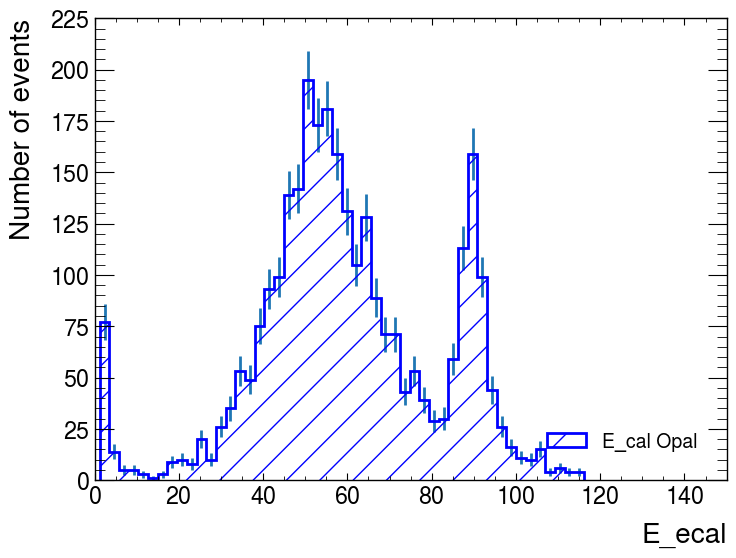

In [6]:
plt.style.use(mplhep.style.ATLAS) # You can load ATLAS/CMS/ALICE plot style 
ratio = [1,4] # ratio of the two subplots

#Opal

bin_content_Opal, bin_edges_Opal, _ = plt.hist(data_Opal.loc[data_Opal['E_lep'] == 44.732]['E_ecal'],bins=50, histtype='step',  linewidth=2, edgecolor='b', hatch='/', label='E_cal Opal')
mid_Opal = 0.5*(bin_edges_Opal[1:] + bin_edges_Opal[:-1]) #Calculate midpoint of the bars

error_sizes = np.sqrt(bin_content_Opal)

plt.errorbar(mid_Opal, bin_content_Opal, yerr=error_sizes, fmt='none')


#plt.ylim(0, 0.7*10**4)  # most of the data



### Show the plot on screen
plt.xlim(0,150)
plt.legend(loc = 4)
plt.xlabel('E_ecal')
plt.ylabel('Number of events')
plt.show()

First determine the number of events in the handronic channel *and* in the three leptonic channels


In [7]:
s_ratio= 0.470464817345979
sigma_ratio = 0.005072534012880613

In [308]:
def classify_event_in_4CH(Ncharged, Pcharged, E_ecal, E_hcal, cos_thet):
    if len(Ncharged)==len(Pcharged)==len(E_ecal)==len(E_hcal):
        #print(Ncharged)
        PI = np.chararray((len(Ncharged),1), itemsize=2)[:]
        PI[:] = 'NC'      # create start PI array with all events unclassified
        NC = 0      
        ee = 0 
        es = 0     
        qq = 0
        mm = 0
        tt = 0
        #print(f'Classification for Energy {meanenergy[I]}:\n')                 
        for i in range(len(Ncharged)):
            
            if (Ncharged[i] >= 7) & (E_ecal[i]>20):
                PI[i] = "qq"
                qq += 1
            elif (E_ecal[i] >= 60): # electron s channel cut
                PI[i] = "ee"
                ee += 1
            elif (70<=Pcharged[i] <= 110):
                PI[i] = "mm"
                mm += 1
            elif (Pcharged[i] < 10) & (E_ecal[i] < 10):
                PI[i] = "mm"
                mm += 1
            elif (E_ecal[i] < 100) & (1 < Pcharged[i] < 75):
                PI[i] = "tt"
                tt += 1
            else:
                PI[i] = "NC"
                NC += 1
        L = len(Ncharged) * 0.470464817345979 # take into account that we only look at the S-channel hece 'Lenght' (total number of events are only number of all ee events times s-channel frac)
        for i in range(len(Ncharged)):
            if (PI[i] == b'ee') & (-0.9 < cos_thet[i] < 0.1): # electron s channel cut
                PI[i] = "es"
                es += 1 * 2.144772117962466 # correct for only selecting part of the S_channel
        #print(PI)
        print('ee, mm, tt, qq, NC,len(Ncharged)')
        print(ee, mm, tt, qq, NC,len(Ncharged))
        print()
    else:
        print('Unequaly long input arrays')
    return [[ee, mm, tt, qq, NC, len(Ncharged)], PI, [es/L, mm/len(Ncharged), tt/len(Ncharged), qq/len(Ncharged), NC/len(Ncharged)],[es, mm, tt, qq, NC, len(Ncharged)]]

### Add particle ID

In [309]:
nchar = data_Opal['Ncharged'].to_numpy()
pchar = data_Opal['Pcharged'].to_numpy()
E_ecal = data_Opal['E_ecal'].to_numpy()
E_hcal = data_Opal['E_hcal'].to_numpy()
cos_thet = data_Opal['cos_thet'].to_numpy()
data_Opal.loc[:, ['ID']] = classify_event_in_4CH(nchar, pchar, E_ecal, E_hcal, cos_thet)[1]
#len(classify_event_in_4CH(nchar, pchar, E_ecal, E_hcal, i)[1])

ee, mm, tt, qq, NC,len(Ncharged)
19643 5113 4692 111084 612 141144



### create callification Matrix sorted by energies

In [311]:
classify_Opal = np.zeros((7,6))
for i in range(0,7,1):
    print(i)
    nchar = data_Opal.loc[data_Opal['COM_energy'] == meanenergy[i]]['Ncharged'].to_numpy()
    pchar = data_Opal.loc[data_Opal['COM_energy'] == meanenergy[i]]['Pcharged'].to_numpy()
    E_ecal = data_Opal.loc[data_Opal['COM_energy'] == meanenergy[i]]['E_ecal'].to_numpy()
    E_hcal = data_Opal.loc[data_Opal['COM_energy'] == meanenergy[i]]['E_hcal'].to_numpy()
    cos_thet = data_Opal.loc[data_Opal['COM_energy'] == meanenergy[i]]['cos_thet'].to_numpy()
    classify_Opal[i] = classify_event_in_4CH(nchar, pchar, E_ecal, E_hcal, cos_thet)[0]
classify_Opal_error = np.sqrt(classify_Opal)

classify_Opal = np.zeros((7,6))
for i in range(0,7,1):
    print(i)
    nchar = data_Opal.loc[data_Opal['COM_energy'] == meanenergy[i]]['Ncharged'].to_numpy()
    pchar = data_Opal.loc[data_Opal['COM_energy'] == meanenergy[i]]['Pcharged'].to_numpy()
    E_ecal = data_Opal.loc[data_Opal['COM_energy'] == meanenergy[i]]['E_ecal'].to_numpy()
    E_hcal = data_Opal.loc[data_Opal['COM_energy'] == meanenergy[i]]['E_hcal'].to_numpy()
    cos_thet = data_Opal.loc[data_Opal['COM_energy'] == meanenergy[i]]['cos_thet'].to_numpy()
    classify_Opal[i] = classify_event_in_4CH(nchar, pchar, E_ecal, E_hcal, cos_thet)[3]
classify_Opal_error = np.sqrt(classify_Opal)

0
ee, mm, tt, qq, NC,len(Ncharged)
1557 98 117 2500 60 4332

1
ee, mm, tt, qq, NC,len(Ncharged)
2438 303 284 6647 75 9747

2
ee, mm, tt, qq, NC,len(Ncharged)
1876 424 391 8771 45 11507

3
ee, mm, tt, qq, NC,len(Ncharged)
8980 3087 2756 66910 276 82009

4
ee, mm, tt, qq, NC,len(Ncharged)
1829 604 550 13006 54 16043

5
ee, mm, tt, qq, NC,len(Ncharged)
1180 288 287 6262 48 8065

6
ee, mm, tt, qq, NC,len(Ncharged)
1783 309 307 6988 54 9441

0
ee, mm, tt, qq, NC,len(Ncharged)
1557 98 117 2500 60 4332

1
ee, mm, tt, qq, NC,len(Ncharged)
2438 303 284 6647 75 9747

2
ee, mm, tt, qq, NC,len(Ncharged)
1876 424 391 8771 45 11507

3
ee, mm, tt, qq, NC,len(Ncharged)
8980 3087 2756 66910 276 82009

4
ee, mm, tt, qq, NC,len(Ncharged)
1829 604 550 13006 54 16043

5
ee, mm, tt, qq, NC,len(Ncharged)
1180 288 287 6262 48 8065

6
ee, mm, tt, qq, NC,len(Ncharged)
1783 309 307 6988 54 9441



In [312]:
classify_Opal_df = pd.DataFrame(dict(zip(['ee', 'mm', 'tt', 'qq', 'NC','length'], classify_Opal.transpose())))
classify_Opal_df['CMS_energies'] = meanenergy
classify_Opal_df = classify_Opal_df.join(pd.DataFrame(classify_Opal_error[:, :4], columns = ['ee_u', 'mm_u', 'tt_u', 'qq_u']))
classify_Opal_df

classify_Opal_df = pd.DataFrame(dict(zip(['es', 'mm', 'tt', 'qq', 'NC','length'], classify_Opal.transpose())))
classify_Opal_df['CMS_energies'] = meanenergy
classify_Opal_df = classify_Opal_df.join(pd.DataFrame(classify_Opal_error[:, :4], columns = ['es_u', 'mm_u', 'tt_u', 'qq_u']))
classify_Opal_df

,es,mm,tt,qq,NC,length,CMS_energies,es_u,mm_u,tt_u,qq_u
0,130.831099,98.0,117.0,2500.0,60.0,4332.0,88.47939,11.438142,9.899495,10.816654,50.000000
1,362.466488,303.0,284.0,6647.0,75.0,9747.0,89.46793,19.038553,17.406895,16.852300,81.529136
2,437.533512,424.0,391.0,8771.0,45.0,11507.0,90.22266,20.917302,20.591260,19.773720,93.653617
3,2861.126005,3087.0,2756.0,66910.0,276.0,82009.0,91.22430,53.489494,55.560778,52.497619,258.669674
4,561.930295,604.0,550.0,13006.0,54.0,16043.0,91.96648,23.705069,24.576411,23.452079,114.043851
5,210.187668,288.0,287.0,6262.0,48.0,8065.0,92.96465,14.497850,16.970563,16.941074,79.132800
6,270.241287,309.0,307.0,6988.0,54.0,9441.0,93.71712,16.439017,17.578396,17.521415,83.594258


(array([1., 0., 1., 0., 0., 1., 0., 0., 1., 0., 3., 1., 1., 2., 0., 1., 0.,
        1., 5., 2., 0., 0., 2., 3., 5., 5., 3., 5., 3., 3., 3., 0., 1., 0.,
        1., 3., 1., 2., 1., 0., 2., 1., 0., 0., 1., 1., 1., 1., 0., 1.]),
 array([ 60.060543,  61.13366 ,  62.206776,  63.279892,  64.35301 ,
         65.426125,  66.499245,  67.57236 ,  68.64548 ,  69.71859 ,
         70.79171 ,  71.86483 ,  72.93794 ,  74.01106 ,  75.084175,
         76.157295,  77.23041 ,  78.30353 ,  79.37664 ,  80.44976 ,
         81.52287 ,  82.59599 ,  83.66911 ,  84.742226,  85.815346,
         86.88846 ,  87.96158 ,  89.03469 ,  90.10781 ,  91.18092 ,
         92.25404 ,  93.32716 ,  94.400276,  95.4734  ,  96.54651 ,
         97.61963 ,  98.69274 ,  99.76586 , 100.838974, 101.912094,
        102.985214, 104.05833 , 105.13145 , 106.20456 , 107.27768 ,
        108.35079 , 109.42391 , 110.497025, 111.570145, 112.64326 ,
        113.71638 ], dtype=float32),
 <BarContainer object of 50 artists>)

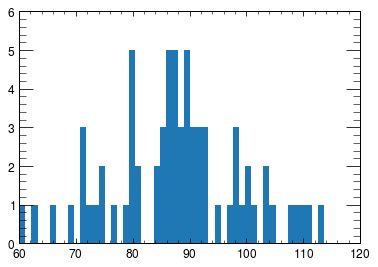

In [313]:
i = 0
plt.hist(data_Opal[(data_Opal['COM_energy'] == meanenergy[i]) & (data_Opal['ID'] == b'ee') & (data_Opal['cos_thet']<=0.25)]['E_ecal'].to_numpy(), bins = 50)

In [314]:
len(data_Opal[(data_Opal['ID'] == b'ee') & (data_Opal['cos_thet']>1)]['cos_thet'].to_numpy())

10214

In [315]:
len(data_Opal[(data_Opal['ID'] == b'ee')]['cos_thet'].to_numpy())

17389

### Correct background and efficency 

* $N_{cut corr} = N_{cut} \epsilon^{-1}$

To get the error on the background and efficency corrected data one has to propagate the $\sqrt{N}$ error with the error of the inverse efficency matrix calculated using a toy MC and propagate it using gaussian error propagation.
* $\Delta N_{cut corr} = \sqrt{(\Delta N_{cut} \epsilon^{-1})^{2} + (N_{cut} \Delta \epsilon^{-1})^{2}}$

In [319]:
Matrix = np.array([[9.941e-01, 0.000e+00, 1.100e-03, 3.000e-04, 4.600e-03],
       [0.000e+00, 9.477e-01, 3.430e-02, 0.000e+00, 1.800e-02],
       [4.030e-02, 7.700e-03, 9.254e-01, 1.230e-02, 1.430e-02],
       [1.000e-03, 0.000e+00, 4.100e-03, 9.947e-01, 2.000e-04]])
Matrix = np.array([[7.08597196e-01, 1.73770282e-03, 9.16824801e-04, 2.66518838e-04,
        3.01699324e-03],
       [4.83024800e-05, 9.56092858e-01, 2.98365137e-02, 0.00000000e+00,
        1.40494379e-02],
       [4.26452110e-02, 2.45032444e-02, 9.17817558e-01, 1.13995001e-02,
        6.00903881e-03],
       [0.00000000e+00, 1.31895336e-04, 4.21050496e-03, 9.94561854e-01,
        1.11603746e-04]])

Matrix_inv = np.linalg.inv(Matrix[:, :4])

Matrix_error_inv = np.array([[4.57926827e-03, 9.67518209e-07, 1.18074831e-04, 5.38185153e-05],
 [3.43399360e-05, 4.92972683e-03, 7.26840606e-04, 1.72674727e-04],
 [2.30087278e-04, 4.17500543e-05, 2.57312975e-04, 4.77883892e-03],
 [7.70717909e-04, 3.31387098e-04, 5.16922627e-03, 4.06636890e-04]])

Matrix_error_inv = np.array([[0.0022, 0.0001, 0.0001, 0.0001, 0.0002],
       [0.    , 0.0045, 0.0006, 0.    , 0.0004],
       [0.    , 0.    , 0.0002, 0.0045, 0.    ],
       [0.0005, 0.0006, 0.0047, 0.0004, 0.0003]])[:, :4]

In [320]:
Ncutcorr = np.zeros((7,4))
Ncutcorr_err = np.zeros((7,4))
Sigma = np.zeros((7,4))
Sigma_err = np.zeros((7,4))
for i in range(0,7,1):
    N_df = pd.DataFrame(classify_Opal_df.loc[classify_Opal_df['CMS_energies'] == meanenergy[i],['es', 'mm', 'tt', 'qq']])
    N_err_df = pd.DataFrame(classify_Opal_df.loc[classify_Opal_df['CMS_energies'] == meanenergy[i],['es_u', 'mm_u', 'tt_u', 'qq_u']])
    N = np.reshape(N_df.to_numpy(dtype=float),4)
    N_err = np.reshape(N_err_df.to_numpy(dtype=float),4)
    Ncor = N.dot(Matrix_inv)
    Nerrcor = np.sqrt( np.square( N.dot(Matrix_error_inv) )+ np.square( N_err.dot(Matrix_inv) ))
    Ncutcorr[i] = Ncor
    Ncutcorr_err[i] = Nerrcor
    sig = Ncor / lumi[i]
    sig_err = np.sqrt( np.square( Nerrcor / lumi[i]) + np.sqrt(Ncor / (lumi[i]**2) * all[i]) )
    Sigma[i] = sig
    Sigma_err[i] = sig_err


### Radiation corrections

In [321]:
hadronic = [2.0, 4.3, 7.7, 10.8, 4.7, -0.2, -1.6]
leptonic = [0.09, 0.20, 0.36, 0.52, 0.22, -0.01, -0.08]

In [322]:
for i in range(0,3,1):
    Sigma[:,i] = Sigma[:,i]+leptonic

Sigma[:,3] = Sigma[:,3]+hadronic

In [323]:
Ncutcorr

array([[  177.85324972,    98.94601033,   112.55673718,  2512.33193609],
       [  495.36065043,   308.21759902,   268.27003763,  6680.13739519],
       [  595.11041015,   431.66715454,   370.94654135,  8814.54758341],
       [ 3881.75746077,  3146.10405588,  2588.13559347, 67245.15093513],
       [  761.76998998,   615.2611478 ,   518.52240497, 13070.96790959],
       [  280.11324411,   292.82574525,   274.02992592,  6293.02392325],
       [  363.79847315,   314.08455506,   291.69835309,  7022.76866678]])

In [324]:
Ncutcorr_err

array([[ 15.54267015,  10.22024595,  16.31121419,  50.16435203],
       [ 26.14725411,  18.50430456,  35.9927311 ,  81.86521149],
       [ 28.79098821,  22.15698264,  46.33456825,  94.07432826],
       [ 82.44236903,  78.42165255, 321.74697964, 262.42711338],
       [ 32.91913709,  27.15617356,  66.22945724, 114.64282673],
       [ 19.73465393,  17.98547784,  34.46425722,  79.45130672],
       [ 22.48356249,  18.72995865,  37.74216774,  83.94325052]])

In [325]:
Sigma_err

array([[0.24571259, 0.21137739, 0.21993828, 0.48413476],
       [0.28474617, 0.25202088, 0.24788337, 0.55421423],
       [0.33056352, 0.30357412, 0.30425361, 0.66665644],
       [0.33729644, 0.32004494, 0.335125  , 0.69394648],
       [0.34232348, 0.32325216, 0.32991174, 0.7180183 ],
       [0.28058682, 0.28306826, 0.28604579, 0.6286178 ],
       [0.25962897, 0.24979264, 0.2495768 , 0.55294034]])

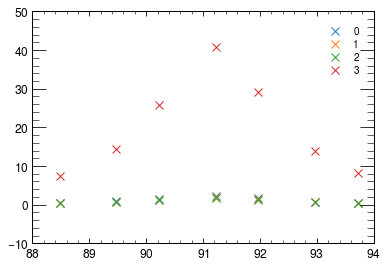

In [326]:
for i in range(0,4,1):
    plt.plot(meanenergy,Sigma[:,i], 'x', label=f'{i}')

plt.legend()

[91.07455954  2.56168304  9.27324115]

[[0.0413226  0.02785335 0.02867667]
 [0.02785335 0.11865312 0.15275922]
 [0.02867667 0.15275922 0.29125688]]
---------------
[91.17873538  2.46320019  7.48822504]

[[0.02249353 0.01520639 0.01662034]
 [0.01520639 0.05993264 0.07155898]
 [0.01662034 0.07155898 0.12771344]]
---------------
[91.16247921  2.60282119  6.83818649]

[[0.02029275 0.01434649 0.01597418]
 [0.01434649 0.05708337 0.06204533]
 [0.01597418 0.06204533 0.1018233 ]]
---------------
[ 91.19028314   2.53682926 161.7548859 ]

[[0.00923318 0.00613378 0.03248486]
 [0.00613378 0.0248056  0.13730285]
 [0.03248486 0.13730285 1.11460867]]
---------------


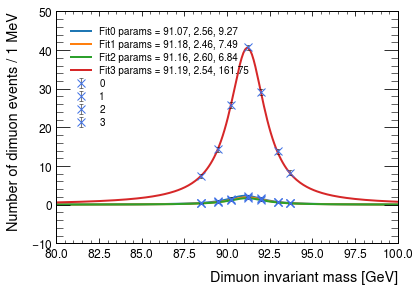

In [347]:
def relativistic_breit_wigner(x, resonance_mass, width, normalization):
    gamma = np.sqrt(resonance_mass ** 2 * (resonance_mass ** 2 + width ** 2))
    k = 2.0 * np.sqrt(2) * resonance_mass * width * gamma / (np.pi * np.sqrt(resonance_mass ** 2 + gamma))
    return normalization * k / ((x ** 2 - resonance_mass ** 2) ** 2 + resonance_mass ** 2 * width ** 2)

for i in range(0,4,1):
    popt, pcov = curve_fit(relativistic_breit_wigner, meanenergy,Sigma[:,i], sigma = Sigma_err[:,i], p0=[90, 10, 30], maxfev = 8000)
    x = np.linspace(80, 100, 200)
    y = relativistic_breit_wigner(x, *popt)
    plt.plot(x, y, label=f'Fit{i} params = {popt[0]:.2f}, {popt[1]:.2f}, {popt[2]:.2f}')
    plt.errorbar(meanenergy,Sigma[:,i], yerr=Sigma_err[:,i] ,marker ='x', ls= '', ms = 8, capsize=2, capthick=0.5,ecolor='black', elinewidth=0.5, color ="#3e70e6",label=f'{i}')
    print(popt)
    print()
    print(np.sqrt(pcov))
    print('---------------')
plt.xlabel('Dimuon invariant mass [GeV]')
plt.ylabel('Number of dimuon events / 1 MeV')
plt.legend()
plt.show()

In [336]:
help(plt.errorbar)

Help on function errorbar in module matplotlib.pyplot:

errorbar(x, y, yerr=None, xerr=None, fmt='', ecolor=None, elinewidth=None, capsize=None, barsabove=False, lolims=False, uplims=False, xlolims=False, xuplims=False, errorevery=1, capthick=None, *, data=None, **kwargs)
    Plot y versus x as lines and/or markers with attached errorbars.
    
    *x*, *y* define the data locations, *xerr*, *yerr* define the errorbar
    sizes. By default, this draws the data markers/lines as well the
    errorbars. Use fmt='none' to draw errorbars without any data markers.
    
    Parameters
    ----------
    x, y : float or array-like
        The data positions.
    
    xerr, yerr : float or array-like, shape(N,) or shape(2, N), optional
        The errorbar sizes:
    
        - scalar: Symmetric +/- values for all data points.
        - shape(N,): Symmetric +/-values for each data point.
        - shape(2, N): Separate - and + values for each bar. First row
          contains the lower errors, 